In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data
import torchvision.utils as utils
import os


In [2]:
#dataset path
data_path_train = "./data/training_adj"
data_path_test = "./data/testing"

In [3]:
# data transform, you can add different transform methods and resize image to any size
img_size = 224
transform = transforms.Compose([
                                transforms.Resize((img_size,img_size)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
                                torchvision.transforms.RandomCrop(img_size, padding=30, pad_if_needed=False, fill=0, padding_mode='constant'),
                                transforms.RandomRotation(degrees=(0, 10)),        
                                transforms.ToTensor()
                                ])

#build dataset
dataset = datasets.ImageFolder(root=data_path_train,transform=transform)

# spilt your data into train and val
TOTAL_SIZE = len(dataset)
ratio = 0.9
train_len = round(TOTAL_SIZE * ratio)
valid_len = round(TOTAL_SIZE * (1-ratio))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, valid_len])

#build dataloader
train_data_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=4)
val_data_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=True,  num_workers=4)

#check dataset
print(dataset)
print(dataset.class_to_idx)

Dataset ImageFolder
    Number of datapoints: 2769
    Root location: ./data/training_adj
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
               RandomAdjustSharpness(sharpness_factor=2,p=0.5)
               RandomCrop(size=(224, 224), padding=30)
               RandomRotation(degrees=[0.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


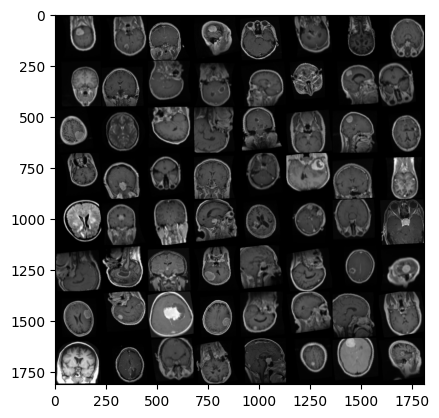

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Model

In [5]:
# using gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#build your model here
# using gpu if available

# instantiate transfer learning model
model_resnet = models.resnet18(pretrained=True)
n_inputs = model_resnet.fc.in_features
model_resnet.fc = nn.Sequential(nn.Linear(n_inputs, 4))

model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = models.vgg16(pretrained=True)

## Modify last layer
num_ftrs = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs,4)
model_vgg.classifier[5] = nn.Dropout(p=0.7, inplace=False)
model_vgg.classifier[2] = nn.Dropout(p=0.7, inplace=False)
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Train

In [7]:
#train function
def train(model, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    
    # Iterate over data
    for inputs, labels in train_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize
        loss.backward()
        optimizer.step()

        # statistics
        total_loss += loss.item()
        total_correct += torch.sum(preds == labels.data).cpu()
        
    avg_loss = total_loss / len(train_data_loader)
    accuracy = total_correct.double() / len(train_dataset) * 100

    print('Training Accuracy: {:.4f}% Training Loss: {:.4f}'.format(accuracy, avg_loss))
    return accuracy , avg_loss

#validation function
def valid(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    
    # Iterate over data
    for inputs, labels in val_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        total_loss += loss.item()
        total_correct += torch.sum(preds == labels.data).cpu()
        
    avg_loss = total_loss / len(val_data_loader)
    accuracy = total_correct.double() / len(val_dataset) * 100

    print('Validation Accuracy: {:.4f}% Validation Loss: {:.4f}'.format(accuracy, avg_loss))
    return accuracy , avg_loss 

In [8]:
####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)
model=model_resnet
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion   = nn.CrossEntropyLoss()
epochs = 20

train_losss=[]
train_accs=[]
val_losss=[]
val_accs=[]


# start training
model.to(device=device)
acc_best = 0.0

print('--------------start training--------------')
for epoch in range(1, epochs+1):
    
    print('epoch:', epoch)
    accuracy_train ,loss_train=train(model, criterion, optimizer)
    accuracy_val ,loss_val = valid(model, criterion)
    train_losss.append(loss_train)
    train_accs.append(accuracy_train)
    val_losss.append(loss_val)
    val_accs.append(accuracy_val)
    
    if accuracy_val > acc_best:
        acc_best = accuracy_val
        print("model saved")
        # save the model
        torch.save(model, "model.pth")

--------------start training--------------
epoch: 1
Training Accuracy: 70.6260% Training Loss: 0.7012
Validation Accuracy: 84.8375% Validation Loss: 0.4526
model saved
epoch: 2
Training Accuracy: 89.8074% Training Loss: 0.2905
Validation Accuracy: 88.8087% Validation Loss: 0.3222
model saved
epoch: 3
Training Accuracy: 92.5762% Training Loss: 0.2024
Validation Accuracy: 88.4477% Validation Loss: 0.2506
epoch: 4
Training Accuracy: 93.9807% Training Loss: 0.1667
Validation Accuracy: 92.0578% Validation Loss: 0.1865
model saved
epoch: 5


KeyboardInterrupt: 

In [9]:
transform_test = transforms.Compose([transforms.Resize((img_size,img_size)),
                                    transforms.ToTensor()
                                    ])

dataset_test = datasets.ImageFolder(root=data_path_test, transform=transform_test)
dataloader_test  = data.DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=4) 

In [10]:
# load the model so that you don't need to train the model again
test_model = torch.load("model.pth").to(device)

In [11]:
def test(model):
    with torch.no_grad():
        model.eval()
        bs = dataloader_test.batch_size
        result = []
        for i, (data, target) in enumerate(dataloader_test):
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1, keepdim=True)
            
            arr = preds.data.cpu().numpy()
            for j in range(preds.size()[0]):
                file_name = dataset_test.samples[i*bs+j][0].split('/')[-1]
                result.append((file_name,preds[j].cpu().numpy()[0]))
    return result

In [12]:
result = test(test_model)

In [13]:
with open ('ID_result.csv','w') as f:
    f.write('ID,label\n')
    for imgs in result:
        f.write(imgs[0]+','+str(imgs[1])+'\n')

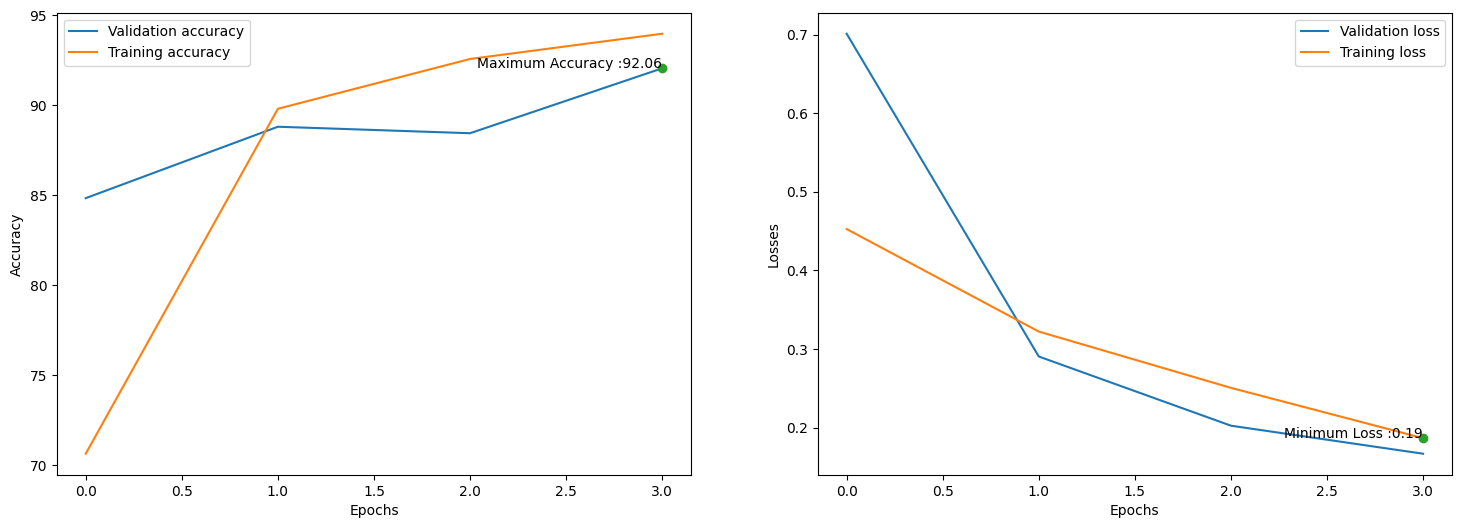

In [14]:
acc_max=np.argmax(val_accs)
loss_min=np.argmin(val_losss)
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(val_accs,label="Validation accuracy")
plt.plot(train_accs,label="Training accuracy")
plt.text(acc_max,val_accs[acc_max],"Maximum Accuracy :"+ str(np.around(val_accs[acc_max].numpy(), decimals=2)),ha='right')
plt.plot(acc_max,val_accs[acc_max],'o') 
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.plot(train_losss,label="Validation loss")
plt.plot(val_losss,label="Training loss")
plt.text(loss_min,val_losss[loss_min],"Minimum Loss :"+ str(np.around(val_losss[loss_min], decimals=2)),ha='right')
plt.plot(loss_min,val_losss[loss_min],'o') 
plt.legend()
plt.show()

# for feature map visualization

In [15]:
def visTensor(tensor, nrow=8, padding=1): 
    n,c,w,h = tensor.shape
    tensor = tensor.view(n*c, -1, w, h)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [16]:
model = torch.load("model.pth").to(device)


#activation dictionary to save activations
activation = {}

#forward hook function
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

#register forward hook
model.conv1.register_forward_hook(get_activation('conv_1'))
        
#pass one image in the training set
iterator = iter(train_data_loader)
model.eval()
inputs, _ = next(iterator)
inputs = inputs.to(device)
outputs = model(inputs[0].unsqueeze(0))

#print out the activations saved
for key in activation:
    print(key)
    print(activation[key].shape)

conv_1
torch.Size([1, 64, 112, 112])


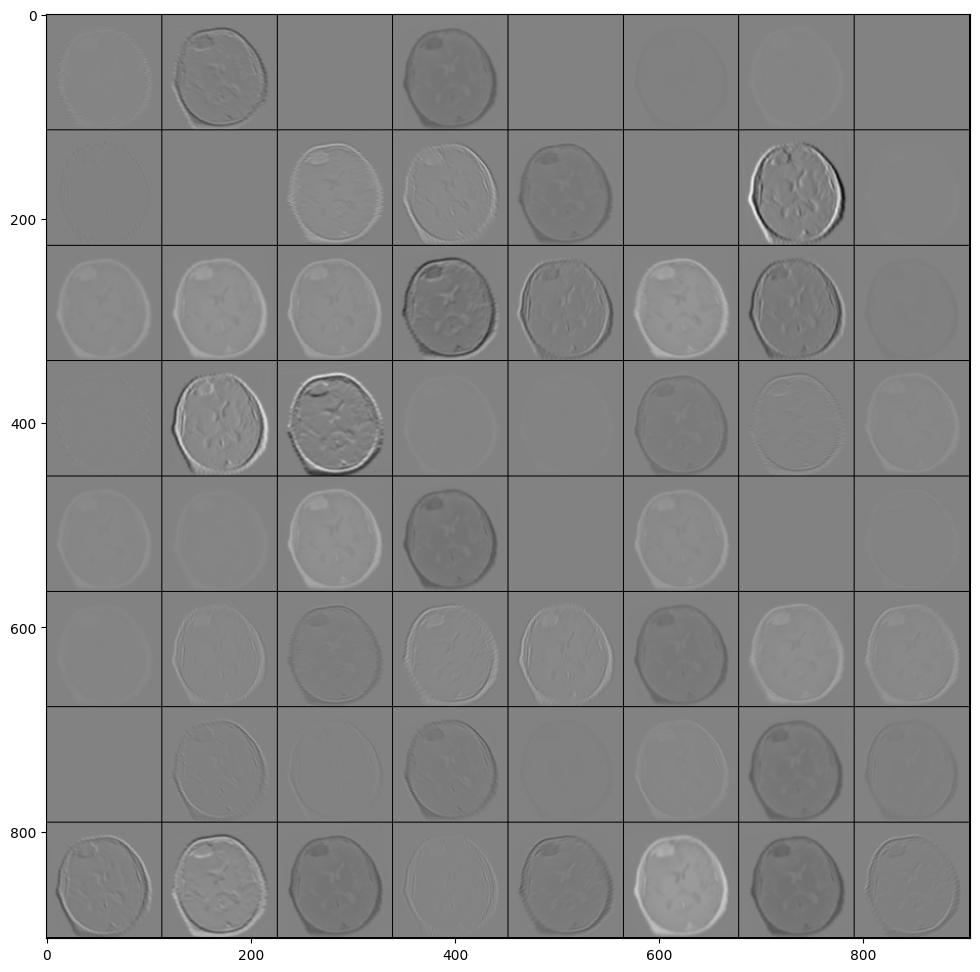

In [17]:
#print only 64 channels
visTensor(activation['conv_1'][:,:64,:,:].cpu().detach().clone(), nrow=8)

In [18]:

for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))
#pass one image in the training set
iterator = iter(train_data_loader)
model.eval()
inputs,_ = next(iterator)
inputs = inputs.to(device)
outputs = model(inputs[0].unsqueeze(0))
#print out the activations saved
for key in activation:
    print(key)
    print(activation[key ].shape)


conv_1
torch.Size([1, 64, 112, 112])
conv1
torch.Size([1, 64, 112, 112])
bn1
torch.Size([1, 64, 112, 112])
relu
torch.Size([1, 64, 112, 112])
maxpool
torch.Size([1, 64, 56, 56])
layer1.0.conv1
torch.Size([1, 64, 56, 56])
layer1.0.bn1
torch.Size([1, 64, 56, 56])
layer1.0.relu
torch.Size([1, 64, 56, 56])
layer1.0.conv2
torch.Size([1, 64, 56, 56])
layer1.0.bn2
torch.Size([1, 64, 56, 56])
layer1.0
torch.Size([1, 64, 56, 56])
layer1.1.conv1
torch.Size([1, 64, 56, 56])
layer1.1.bn1
torch.Size([1, 64, 56, 56])
layer1.1.relu
torch.Size([1, 64, 56, 56])
layer1.1.conv2
torch.Size([1, 64, 56, 56])
layer1.1.bn2
torch.Size([1, 64, 56, 56])
layer1.1
torch.Size([1, 64, 56, 56])
layer1
torch.Size([1, 64, 56, 56])
layer2.0.conv1
torch.Size([1, 128, 28, 28])
layer2.0.bn1
torch.Size([1, 128, 28, 28])
layer2.0.relu
torch.Size([1, 128, 28, 28])
layer2.0.conv2
torch.Size([1, 128, 28, 28])
layer2.0.bn2
torch.Size([1, 128, 28, 28])
layer2.0.downsample.0
torch.Size([1, 128, 28, 28])
layer2.0.downsample.1
torch

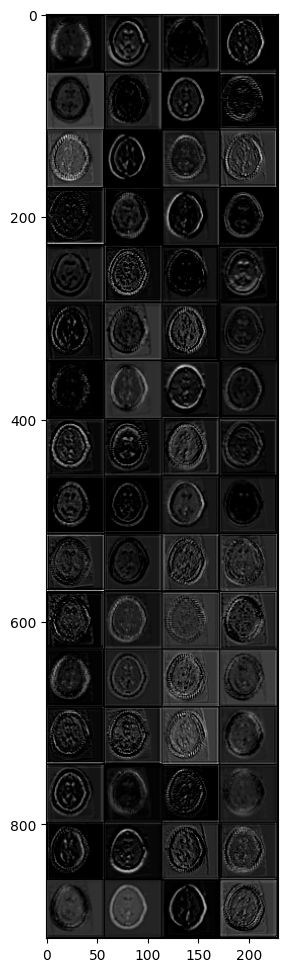

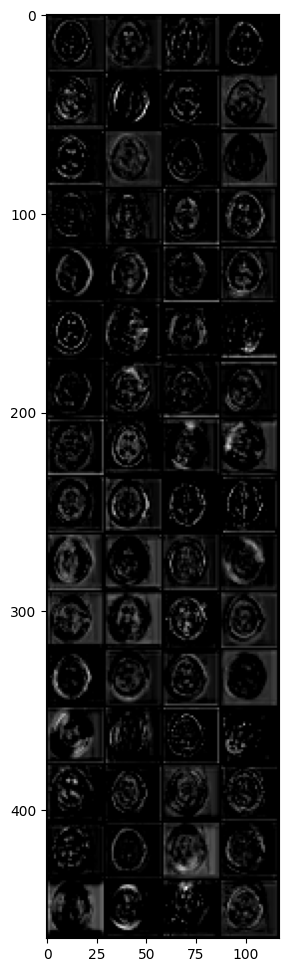

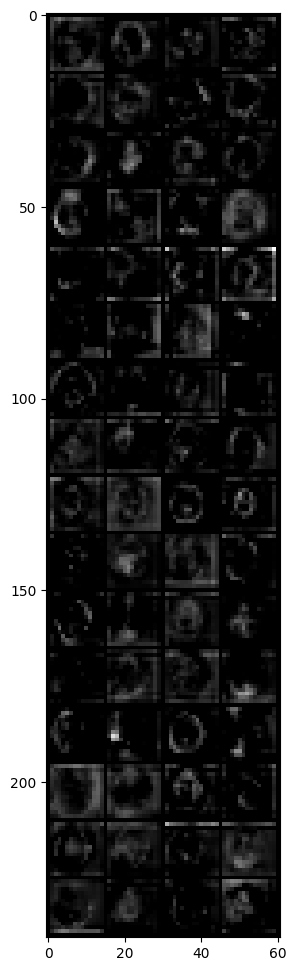

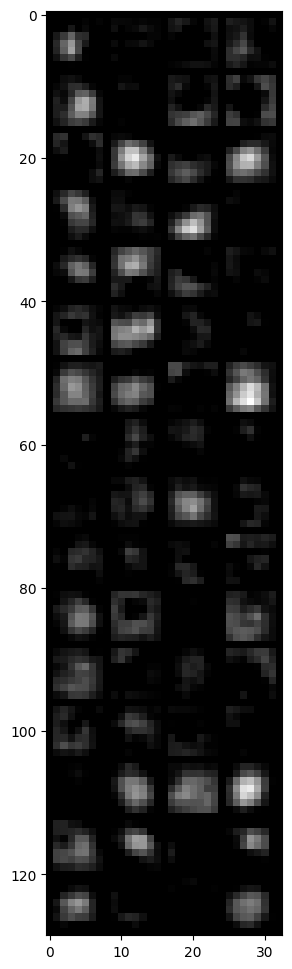

In [20]:
visTensor(activation['layer1'][:,:64,:,:].cpu().detach().clone(), nrow=4)
visTensor(activation['layer2'][:,:64,:,:].cpu().detach().clone(), nrow=4)
visTensor(activation['layer3'][:,:64,:,:].cpu().detach().clone(), nrow=4)
visTensor(activation['layer4'][:,:64,:,:].cpu().detach().clone(), nrow=4)